Plots for the experiments comparing DSCO (Li), C-OCBA (Gao), IKG (ML_IKG), and
GP-C-OCBA (ML_Gao).

In [1]:
import json
import os

import torch
from torch import Tensor

%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Arial"


# current_dir = os.path.dirname(os.path.abspath(__file__))
current_dir = os.getcwd()

plot_kwargs = {
    "ML_IKG": {"ls": "-.", "marker": "p", "color": u'#e377c2'},
    "ML_Gao": {"ls": "-.", "marker": "d", "color": u'#d62728'},
    "Li": {"marker": "o", "color": u'#ff7f0e'},
    "Gao": {"marker": "+", "color": u'#2ca02c'},
}
plot_titles = {
    "config_b_3_mean": "Branin function, expected PCS",
    "config_b_3_worst": "Branin function, worst-case PCS",
    "config_g_4_mean": "Griewank function, expected PCS",
    "config_g_4_worst": "Griewank function, worst-case PCS",
    "config_h_4_mean": "Hartmann function, expected PCS",
    # "config_l_3_worst": "Levy function, worst-case PCS",
    "config_c_5_mean": "Cosine8 function, expected PCS",
}
labels = {
    "ML_IKG": "IKG",
    "ML_Gao": "GP-C-OCBA",
    "Li": "DSCO",
    "Gao": "C-OCBA"
}

all_keys = list(plot_kwargs.keys())
plot_idcs = None
moving_average_window = 1
plot_errors = False
figsize = (5.4, 3.2)
# figsize = (16, 12)


def plot_experiment(
    dirname: str, plot_idcs: list = plot_idcs, empirical_pcs: bool = False,
) -> Tensor:
    exp_dir = os.path.join(current_dir, dirname)
    config_path = os.path.join(exp_dir, "config.json")

    with open(config_path, "r") as f:
        config_dict = json.load(f)
        print(f"Config: \n {json.dumps(config_dict, indent=4)}")
    expected_iterations = config_dict["iterations"]

    # get all the output files
    directory_list = os.listdir(exp_dir)
    output_files = [
        os.path.join(exp_dir, file) for file in directory_list if file[-3:] == ".pt"
    ]
    print(f"Found {len(output_files)} output files.")

    # plot final values, averaged over replications.
    # final values is a list of tensors, one tensor per label
    if empirical_pcs:
        key = "rho_cs"
    else:
        key = "pcs_estimates"

    output_lists = [list() for _ in all_keys]
    wall_times = [0.] * len(all_keys)
    time_counts = [0] * len(all_keys)
    for out_path in output_files:
        out_dict = torch.load(out_path)
        label_idx = all_keys.index(out_dict["label"])
        output = out_dict[key].cpu()
        # This is handling a small mistake in rho implementation
        if "weights" in config_dict and empirical_pcs:
            output *= config_dict["num_contexts"]
        if output.shape[0] == expected_iterations or \
                (output.shape[0] == 1000 and label_idx == 0 and ("h_4" in dirname or
                                                                 "c_5" in dirname)):
            output_lists[label_idx].append(output)
            wall_times[label_idx] += float(out_dict["wall_time"][999])
            time_counts[label_idx] += 1

    # calculate the mean and std for plotting
    key_counts = list()
    plot_means = list()
    plot_stds = list()
    for out_list in output_lists:
        try:
            out_tensor = torch.stack(out_list)
            key_counts.append(out_tensor.shape[0])
            mean = out_tensor.mean(dim=0)
            std = out_tensor.std(dim=0)
            if moving_average_window > 1:
                tmp_mean = torch.zeros_like(mean)
                tmp_std = torch.zeros_like(std)
                for i in range(tmp_mean.shape[0]):
                    l_ind = max(0, i - moving_average_window)
                    tmp_mean[i] = torch.mean(mean[l_ind: i+1])
                    tmp_std[i] = torch.mean(std[l_ind: i+1])
                mean = tmp_mean
                std = tmp_std
            plot_means.append(mean)
            plot_stds.append(std)
        except:
            key_counts.append(0)
            plot_means.append(None)
            plot_stds.append(None)

    print(f"Plotting {key_counts} outputs!")

    for i in range(len(all_keys)):
        if wall_times[i]:
            wall_times[i] /= time_counts[i]

    print(f"average wall times {wall_times}")

    # plot
    fig = plt.figure(figsize=figsize)

    if plot_idcs is None:
        plot_idcs = range(len(key_counts))

    for i in plot_idcs:
        if plot_means[i] is None:
            continue
        if plot_errors:
            plt.errorbar(
                x=torch.arange(plot_means[i].shape[0]),
                y=plot_means[i],
                yerr=plot_stds[i],
                errorevery=20,
                label=labels[all_keys[i]],
                markevery=20,
                **plot_kwargs[all_keys[i]]
            )
        else:
            plt.plot(
                plot_means[i],
                label=labels[all_keys[i]],
                markevery=20,
                **plot_kwargs[all_keys[i]]
            )
    plt.grid()
    plt.legend(prop={'size': 12})
    plt.title(plot_titles[dirname], fontdict={"fontsize": 16})
    plt.savefig(os.path.join("plots", dirname + ".pdf"), dpi=300)
    fig.patch.set_facecolor('xkcd:mint green')
    plt.show()
    return output_lists




Config: 
 {
    "iterations": 2000,
    "fit_frequency": 10,
    "num_arms": 10,
    "num_contexts": 10,
    "use_full_train": 1,
    "weights": [
        0.03,
        0.07,
        0.2,
        0.1,
        0.15,
        0.2,
        0.02,
        0.08,
        0.1,
        0.05
    ],
    "rho_key": "mean",
    "ground_truth_kwargs": {
        "function": "branin"
    }
}
Found 400 output files.
Plotting [100, 100, 100, 100] outputs!
average wall times [1235.2016484308242, 250.09987884759903, 12.25713710308075, 10.692327938079835]


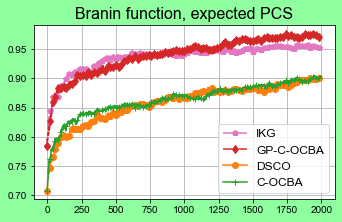

In [2]:
# _ = plot_experiment("config_b_3_mean")
_ = plot_experiment("config_b_3_mean", empirical_pcs=True)

Config: 
 {
    "iterations": 2000,
    "fit_frequency": 10,
    "num_arms": 10,
    "num_contexts": 10,
    "use_full_train": 1,
    "rho_key": "worst",
    "ground_truth_kwargs": {
        "function": "branin"
    }
}
Found 400 output files.
Plotting [100, 100, 100, 100] outputs!
average wall times [1202.3295753908158, 247.16513070583343, 11.785177755355836, 9.94606247663498]


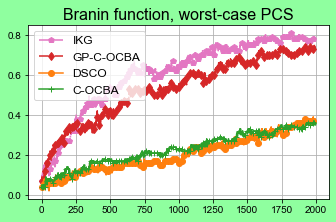

In [3]:
# _ = plot_experiment("config_b_3_worst")
_ = plot_experiment("config_b_3_worst", empirical_pcs=True)

Config: 
 {
    "iterations": 2000,
    "fit_frequency": 10,
    "num_arms": 10,
    "num_contexts": 20,
    "use_full_train": 1,
    "rho_key": "mean",
    "ground_truth_kwargs": {
        "function": "greiwank"
    }
}
Found 400 output files.
Plotting [100, 100, 100, 100] outputs!
average wall times [4209.96838870287, 279.6368484568596, 24.010733547210695, 17.228006265163422]


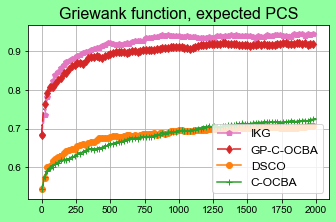

In [4]:
# _ = plot_experiment("config_g_4_mean")
_ = plot_experiment("config_g_4_mean", empirical_pcs=True)

Config: 
 {
    "iterations": 2000,
    "fit_frequency": 10,
    "num_arms": 10,
    "num_contexts": 20,
    "use_full_train": 1,
    "rho_key": "worst",
    "ground_truth_kwargs": {
        "function": "greiwank"
    }
}
Found 400 output files.
Plotting [100, 100, 100, 100] outputs!
average wall times [4062.0289201927185, 314.10366139888765, 26.083792600631714, 19.774411644935608]


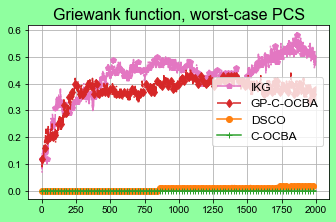

In [5]:
# _ = plot_experiment("config_g_4_worst")
_ = plot_experiment("config_g_4_worst", empirical_pcs=True)

Config: 
 {
    "iterations": 2000,
    "fit_frequency": 10,
    "num_arms": 20,
    "num_contexts": 20,
    "context_dim": 2,
    "use_full_train": 0,
    "rho_key": "mean",
    "ground_truth_kwargs": {
        "function": "hartmann"
    }
}
Found 200 output files.
Plotting [100, 100, 0, 0] outputs!
average wall times [11096.50577392578, 441.4668376469612, 0.0, 0.0]


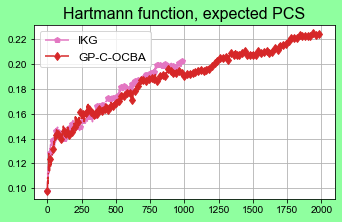

In [6]:
# _ = plot_experiment("config_h_4_mean")
_ = plot_experiment("config_h_4_mean", empirical_pcs=True)

In [7]:
# _ = plot_experiment("config_p_4_worst")
# _ = plot_experiment("config_p_4_worst", empirical_pcs=True)

In [8]:
# _ = plot_experiment("config_l_4_worst")
# _ = plot_experiment("config_l_4_worst", empirical_pcs=True)

In [9]:
# _ = plot_experiment("config_l_3_worst")
# _ = plot_experiment("config_l_3_worst", empirical_pcs=True)

Config: 
 {
    "iterations": 2000,
    "fit_frequency": 10,
    "num_arms": 20,
    "num_contexts": 40,
    "context_dim": 7,
    "use_full_train": 0,
    "rho_key": "mean",
    "ground_truth_kwargs": {
        "function": "cosine8"
    }
}
Found 200 output files.
Plotting [100, 100, 0, 0] outputs!
average wall times [43224.342271125315, 544.6082647371292, 0.0, 0.0]


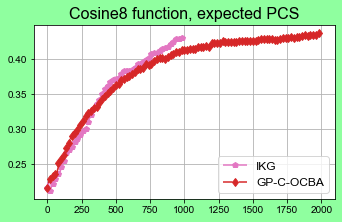

In [10]:
# _ = plot_experiment("config_c_5_mean")
_ = plot_experiment("config_c_5_mean", empirical_pcs=True)